In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#/kaggle/input/scence-data/train.csv
#/kaggle/input/scence-data/test.csv
#/kaggle/input/scence-data/train/img_num.jpg


In [2]:
import numpy as np  
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import skimage
from skimage.io import imshow,imread,imsave
from skimage.transform import resize

# importing libraries for defining the architecture of model
import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.nn import Linear, ReLU, BCELoss, Sequential, Softmax

# import torchvision
from torchvision.models import resnet34
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
#defining preprocessing steps
normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
preprocessing=transforms.Compose([transforms.ToTensor(),normalize,transforms.Resize((240,240))])

In [4]:
#defining class to load the dataset
class SceneDataset(Dataset):
    def __init__(self,img_dir,csv_path,transform):
        self.img_dir=img_dir
        self.csv_path = csv_path
        df=pd.read_csv(csv_path)
        self.image_name = df.image_name.values
        self.y = df.label.values
        self.transform=transform
        
    #to read img and labels with index
    def __getitem__(self,index):
        img=imread(self.img_dir+self.image_name[index])
        
        if self.transform is not None:
            img = self.transform(img)
        
        label=self.y[index]
        
        return img,label
    
    
    def __len__(self):
        return self.y.shape[0]
            
        
        

In [5]:
train_dataset=SceneDataset(img_dir='/kaggle/input/scence-data/train/',
                          csv_path='/kaggle/input/scence-data/train.csv',
                          transform=preprocessing)

In [6]:
train_loader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)

In [7]:
# getting the first batch
for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
   break

In [8]:
batch_x.shape,batch_y.shape    #32,3,150,150 - 32-batch size, 150*150- size, 3 no.of channels

(torch.Size([32, 3, 240, 240]), torch.Size([32]))

In [9]:
batch_x[0]   #pixel value for 1st image

tensor([[[-0.2342, -0.2267, -0.2171,  ...,  0.6552,  0.6659,  0.6734],
         [-0.2192, -0.2150, -0.2091,  ...,  0.6922,  0.6950,  0.6959],
         [-0.1989, -0.1989, -0.1978,  ...,  0.7442,  0.7372,  0.7302],
         ...,
         [-1.9873, -1.9620, -1.9168,  ..., -1.3284, -1.7334, -2.0462],
         [-1.9905, -1.9048, -1.7921,  ..., -1.0000, -1.3721, -1.6620],
         [-1.9980, -1.8632, -1.6951,  ..., -0.7832, -1.1001, -1.3473]],

        [[-0.0224, -0.0147, -0.0049,  ...,  0.1899,  0.1778,  0.1702],
         [-0.0071, -0.0028,  0.0032,  ...,  0.1966,  0.1855,  0.1778],
         [ 0.0137,  0.0137,  0.0148,  ...,  0.2074,  0.1981,  0.1910],
         ...,
         [-1.9372, -1.9186, -1.8816,  ..., -1.1225, -1.5974, -1.9602],
         [-1.9307, -1.8507, -1.7459,  ..., -0.6968, -1.1331, -1.4711],
         [-1.9307, -1.8005, -1.6396,  ..., -0.4087, -0.7818, -1.0728]],

        [[ 1.8383,  1.8459,  1.8557,  ...,  1.5953,  1.5942,  1.5942],
         [ 1.8383,  1.8425,  1.8485,  ...,  1

### Load Pretrain Resnets model

In [10]:
resnet = resnet34(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [11]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
if torch.cuda.is_available():
    resnet=resnet.cuda()

In [13]:
#undestanding output of resnet for 1st 2 imgae
input=batch_x[:2]
input=input.cuda()
features=resnet(input)
features.shape

torch.Size([2, 1000])

### Fine tune the model for the current problem
Steps:-

Extract the features

Flatten the data

Define a Neural Network Model

Compile the model

Train the model

In [14]:
device='cuda' if torch.cuda.is_available else 'cpu'

In [15]:
features=[]
targets=[]
time_eclapsed=[]

resnet.eval()

with torch.no_grad():
    
    for idx,(batch_x,batch_y) in enumerate(train_loader):
        batch_x=batch_x.to(device)
    
     #to record the time for extracting features
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
    
        start.record()
    
        batch_features = resnet(batch_x)
    
        end.record()
    
    #wait for everyting to synchronize
        torch.cuda.synchronize()
    
        time_eclapsed.append(start.elapsed_time(end))
    
        batch_features = batch_features.data.cpu().numpy()
    
        features.append(batch_features)
        targets.append(batch_y)
    
    
    
#save to the array
features = np.concatenate(features, axis=0)
targets = np.concatenate(targets, axis=0)    



In [16]:
features.shape,targets.shape   #17034 image, 1000 features

((17034, 1000), (17034,))

In [17]:
# time taken to extract features
print('Time taken in seconds: ', torch.sum(torch.tensor(time_eclapsed)*0.001))

Time taken in seconds:  tensor(15.6258)


In [18]:
# creating the training and validation data
X_train, X_valid, Y_train, Y_valid = train_test_split(features, targets, test_size=0.3, stratify=targets, random_state=42)

In [19]:
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((11923, 1000), (5111, 1000), (11923,), (5111,))

In [20]:
# converting training and validation set to PyTorch tensor
X_train = torch.FloatTensor(X_train)
Y_train = torch.FloatTensor(Y_train)

X_valid = torch.FloatTensor(X_valid)
Y_valid = torch.FloatTensor(Y_valid)


Y_train = Y_train.long()
Y_valid = Y_valid.long()

**Define Neural Network**

In [21]:
model=Sequential(Linear(1000,64),
                ReLU(),
                Linear(64,6),
                Softmax())

In [22]:
model

Sequential(
  (0): Linear(in_features=1000, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=6, bias=True)
  (3): Softmax(dim=None)
)

In [23]:
ind = 10
print(model(X_train[ind]), "\n", Y_train[ind], torch.argmax(model(X_train[ind])))

tensor([0.3164, 0.0695, 0.2510, 0.1815, 0.0977, 0.0839],
       grad_fn=<SoftmaxBackward0>) 
 tensor(3) tensor(0)


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


**COmpiling the model**

In [24]:
optimizer=torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

#putting model and criterion to gpu if available
model.to(device)
criterion.to(device)

CrossEntropyLoss()

In [25]:
#define metric
def multi_class_acc(preds,y):
    
    round_preds=torch.argmax(preds,dim=1)  #dims=1 will return max index value for each row
    
    #no.of correct classify
    correct = (round_preds==y).float()
    
    #compute acc
    acc = correct.sum()/len(correct)
    
    return acc
                           

In [26]:
def train(X,Y,batch_size):
    
    model.train()
    
    #initialization
    epoch_loss,epoch_acc=0,0
    num_of_batches=0
    
    #randomly create index
    index=torch.randperm(len(X))
    
    for i in range(0,len(index),batch_size):
        #print("training")
        ind=index[i:i+batch_size]
        
        batch_x=X[ind]
        batch_y=Y[ind]
        
        batch_y = batch_y.type(torch.LongTensor)
        
        batch_x=batch_x.to(device)
        batch_y=batch_y.to(device)
        
        optimizer.zero_grad()
        
        outputs=model(batch_x)
        
        #squezing outputs
        
        outputs.squeeze()
        
        loss = criterion(outputs,batch_y)
        acc = multi_class_acc(outputs, batch_y) 
        
        #backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Keep track of the loss and accuracy of a epoch
        epoch_loss = epoch_loss + loss.item()
        epoch_acc  = epoch_acc  + acc.item()
        
        num_of_batches = num_of_batches+1
        
    return epoch_loss/num_of_batches, epoch_acc/num_of_batches
        
        

In [27]:
def evaluate(X,Y,batch_size):
    
     # deactivate training phase
    model.eval()
    
    epoch_loss,epoch_acc=0,0
    num_of_batches=0
    
    #randomly create index
    index=torch.randperm(len(X))
    
    with torch.no_grad():
        
        for i in range(0,len(index),batch_size):
            
            ind=index[i:i+batch_size]
        
            batch_x=X[ind]
            batch_y=Y[ind]
        
            batch_y = batch_y.type(torch.LongTensor)
        
            batch_x=batch_x.to(device)
            batch_y=batch_y.to(device)
        
            optimizer.zero_grad()
        
            outputs=model(batch_x)
        
            #squezing outputs
        
            outputs.squeeze()
        
            loss = criterion(outputs,batch_y)
            acc = multi_class_acc(outputs, batch_y) 
        
            
        
            # Keep track of the loss and accuracy of a epoch
            epoch_loss = epoch_loss + loss.item()
            epoch_acc  = epoch_acc  + acc.item()
        
            num_of_batches=num_of_batches+1
        
    return epoch_loss/num_of_batches, epoch_acc/num_of_batches
    
    
    
   

 
    
    

In [28]:
# define prediction function
def predict(X,batch_size):
  
  # deactivate training phase
    model.eval()

  # initialization 
    predictions = []

  # create indices
    indices = torch.arange(len(X))

  # deactivates autograd
    with torch.no_grad():
      
      for i in range(0, len(X), batch_size):
        
        # indices for a batch
        ind = indices[i:i+batch_size]

        # batch
        batch_x = X[ind]

        # push to cuda
        if torch.cuda.is_available():
            batch_x = batch_x.cuda()

        # forward pass
        outputs = model(batch_x)

        # converting the output to 1 Dimensional tensor
        outputs = outputs.squeeze()

        # convert to numpy array
        prediction = outputs.data.cpu().numpy()
        predictions.append(prediction)
    
  # convert to single numpy array
    predictions = np.concatenate(predictions, axis=0)
    
    return predictions

In [29]:
N_EPOCHS = 50
batch_size = 32

# intialization
best_valid_acc = 0

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc  = train(X_train, Y_train, batch_size)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(X_valid, Y_valid, batch_size)

    print('\nEpoch :',epoch,
          'Training loss:',round(train_loss,4),
          '\tTrain Accuracy:',round(train_acc,4),
          '\tValidation loss:',round(valid_loss,4),
          '\tValidation Accuracy:',round(valid_acc,4))

    #save the best model
    if best_valid_acc <= valid_acc:
        best_valid_acc = valid_acc
        torch.save(model.state_dict(), 'saved_weights.pt') 
        print("\n----------------------------------------------------Saved best model------------------------------------------------------------------")   


Epoch : 0 Training loss: 1.1733 	Train Accuracy: 0.8752 	Validation loss: 1.1452 	Validation Accuracy: 0.8986

----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 1 Training loss: 1.1379 	Train Accuracy: 0.9071 	Validation loss: 1.1401 	Validation Accuracy: 0.9036

----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 2 Training loss: 1.1335 	Train Accuracy: 0.9111 	Validation loss: 1.1368 	Validation Accuracy: 0.9058

----------------------------------------------------Saved best model------------------------------------------------------------------

Epoch : 3 Training loss: 1.1308 	Train Accuracy: 0.9122 	Validation loss: 1.1378 	Validation Accuracy: 0.9049

Epoch : 4 Training loss: 1.1285 	Train Accuracy: 0.9153 	Validation loss: 1.1437 	Validation Accuracy: 0.8994

Epoch : 5 Training loss: 1.1271 	Tra

In [30]:
path='saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [31]:
# performance on validation set
valid_loss, valid_accuracy = evaluate(X_valid,Y_valid,batch_size)

print("Validation Accuracy:",(valid_accuracy)*100)

Validation Accuracy: 91.86735734343529


**On text data**

In [32]:
def test_img_loader(path):
    with open(path,"rb") as f:
        img=Image.open(f)
        return img.convert('RGB')
        #return img

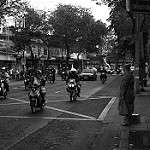

In [33]:
test_img_loader("/kaggle/input/scence-data/train/3.jpg")

In [34]:
class Test_Scene_Data(Dataset):
    def __init__(self,csv_path,img_dir,transform):
        df_test=pd.read_csv(csv_path)
        self.csv_path=csv_path
        self.img_dir=img_dir
        self.img_names=df_test.image_name.values
        self.transform=transform
        
    def __getitem__(self,index):
        img=test_img_loader(self.img_dir + self.img_names[index])
        if self.transform is not None:
            img=self.transform(img)
            
        return img
    
    def __len__(self):
        return self.img_names.shape[0]
            
        
        

In [35]:
test_dataset = Test_Scene_Data(csv_path="/kaggle/input/scence-data/test.csv",
                              img_dir='/kaggle/input/scence-data/train/',
                              transform=preprocessing)

In [36]:
test_dataloader = DataLoader(dataset=test_dataset,batch_size=32,shuffle=True)

In [37]:
test_dataloader

In [38]:
for batch_idx, batch_x in enumerate(test_dataloader):
    break

In [39]:
batch_x.shape

torch.Size([32, 3, 240, 240])

In [40]:
#extract features

features=[]
elapsed_time=[]
target=[]

model.eval()

with torch.no_grad():
    
    for idx,(batch_x) in enumerate(test_dataloader):
        batch_x=batch_x.to(device)
        
        start=torch.cuda.Event(enable_timing=True)
        end=torch.cuda.Event(enable_timing=True)
        
        start.record()
        
        batch_features = resnet(batch_x)
        
        end.record()
        
        torch.cuda.synchronize()
        
        batch_features = batch_features.data.cpu().numpy()
        
        features.append(batch_features)
        
        elapsed_time.append(start.elapsed_time(end))
        
  #save to the array
features = np.concatenate(features, axis=0)      
        
        

In [41]:
features.shape

(7301, 1000)

In [42]:
#flattening features
features=features.reshape(len(features),-1)
features.shape

(7301, 1000)

In [43]:
X_test_img = torch.FloatTensor(features)

In [44]:
X_test_img.shape

torch.Size([7301, 1000])

In [45]:
# predictions of test set
predicted = predict(X_test_img,batch_size)
predicted

array([[3.6166575e-06, 2.4005368e-25, 1.5359629e-21, 1.3628647e-15,
        1.7245793e-04, 9.9982399e-01],
       [1.1476634e-42, 1.7399128e-26, 1.0000000e+00, 3.2194513e-14,
        2.0630904e-30, 1.8479740e-30],
       [2.4662853e-43, 1.9207598e-41, 1.0000000e+00, 2.9553112e-13,
        2.3635955e-37, 1.9909434e-33],
       ...,
       [6.3045641e-31, 3.0380151e-41, 4.1525890e-24, 4.0855680e-27,
        1.0000000e+00, 1.5718619e-34],
       [2.7063417e-40, 2.1496440e-27, 1.0000000e+00, 8.1689160e-26,
        1.2887530e-27, 6.2824498e-39],
       [3.3752575e-17, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        5.7186990e-42, 5.0761294e-39]], dtype=float32)

In [46]:
test_result = np.argmax(predicted,axis=1) 
test_result

array([5, 2, 2, ..., 4, 2, 1])

In [47]:
df = pd.DataFrame(test_dataset.img_names,columns=['image_name'])
df['label'] = test_result


df.head(15)

,image_name,label
0,3.jpg,5
1,5.jpg,2
2,6.jpg,2
3,11.jpg,1
4,14.jpg,1
5,22.jpg,5
6,25.jpg,1
7,28.jpg,0
8,30.jpg,2
9,38.jpg,3


In [48]:
# saving the  results
df.to_csv('test_result.csv', index=False,  header = True)

In [49]:
i1=test_img_loader("/kaggle/input/scence-data/train/5.jpg")

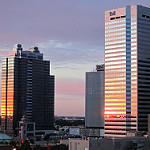

In [50]:
i1

In [51]:
i1=preprocessing(i1)

i1.shape

torch.Size([3, 240, 240])

In [52]:
i1=i1.unsqueeze(0)
i1=i1.to(device)
i1.shape

torch.Size([1, 3, 240, 240])

In [53]:
feat=resnet(i1)

In [54]:
feat=feat.data.cpu().numpy()

In [55]:
X1 = torch.FloatTensor(feat)


In [56]:
model.eval()
with torch.no_grad():
    X1=X1.to(device)
    
    out=model(X1)
    out = out.squeeze()
    

        # convert to numpy array
    prediction = out.data.cpu().numpy()
    

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [57]:
prediction

array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.8525166e-41,
       3.8757513e-31, 2.8068633e-35], dtype=float32)

In [58]:
test_result = np.argmax(prediction,axis=0) 
test_result

0

In [59]:
def mapp_img(label):
    if label==0:
        l="Buildings"
    elif label==1:
        l="Forest"
    elif label==2:
        l="Glaciers"
    elif label==3:
        l="Mountain"
    elif label==4:
        l="Sea"
    elif label==5:
        l="Street"
    
    return l
#label.map({0:'Buildings',1:"Forest",2:"Glacier",3:"Mountain",4:"Sea",5:"Street"})


In [60]:
def single_img(path):
    
    i1=test_img_loader(path)
    
    i2=preprocessing(i1)
    
    i2=i2.unsqueeze(0)
    i2=i2.to(device)
    
    
    feat=resnet(i2)
    feat=feat.data.cpu().numpy()
    
    X1 = torch.FloatTensor(feat)
    
    model.eval()
    with torch.no_grad():
        X1=X1.to(device)
    
        out=model(X1)
        out = out.squeeze()
    

        # convert to numpy array
        prediction = out.data.cpu().numpy()
        
    test_result = np.argmax(prediction,axis=0)
    #test_result=list(test_result)
    
    test_result=mapp_img(test_result)
    

    
    return test_result

    
    
    

In [61]:
#import random
#ind=random.randint(0,1000)
#print(ind)




#single_img("/kaggle/input/scence-data/train/{}.jpg".format(ab))
single_img("/kaggle/input/scence-data/train/24.jpg")

'Glaciers'

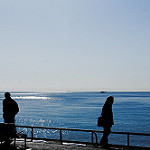

In [62]:
path="/kaggle/input/scence-data/train/25.jpg"
img_nu = test_img_loader(path)
img_nu

In [63]:
single_img(path)

'Sea'